# Lendo Parquet (S3)

In [1]:
import sys
!{sys.executable} -m pip install pyarrow

    100% |████████████████████████████████| 48.5MB 13kB/s  eta 0:00:01
You are using pip version 9.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [31]:
import s3fs
import pyarrow.parquet as pq
from pyarrow.filesystem import S3FSWrapper

fs = s3fs.S3FileSystem()
bucket = "treinamento-big-data-aws"
path = "Turma_20190701/BrunoJ"

# Python 3.6 or later
p_dataset = pq.ParquetDataset(
    f"s3://{bucket}/{path}",
    filesystem=fs
)
df = p_dataset.read().to_pandas()

df.head()

,SK_ID_CURR,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,FLAG_CONT_MOBILE,AMT_INCOME_TOTAL,TARGET
0,100002,406597.5,24700.5,-9461,1,202500.0,1
1,100003,1293502.5,35698.5,-16765,1,270000.0,0
2,100004,135000.0,6750.0,-19046,1,67500.0,0
3,100006,312682.5,29686.5,-19005,1,135000.0,0
4,100007,513000.0,21865.5,-19932,1,121500.0,0


# Gerando Metadados 

In [32]:
def AjusteMetadados(dataframe): 
    import pandas as pd
    train = dataframe
    # Verifica os tipos de variáveis presentes na tabela de treino
    t = []
    for i in train.columns:
            t.append(train[i].dtype)

    n = []
    for i in train.columns:
            n.append(i)

    aux_t = pd.DataFrame(data=t,columns=["Tipos"])
    aux_n = pd.DataFrame(data=n,columns=["Features"])
    df_tipovars = pd.concat([aux_n, aux_t], axis=1, join_axes=[aux_n.index])

    data = []
    for f in train.columns:

        # Definindo o papel das variáveis:
        if f == 'target':
            role = 'target'
        elif f == 'id':
            role = 'id'
        else:
            role = 'input'

        # Definindo o tipo das variáveis: nominal, ordinal, binary ou interval
        if f == 'target':
            level = 'binary'
        if train[f].dtype == 'object' or f == 'id': 
            level = 'nominal'
        elif train[f].dtype in ['float','float64'] :
            level = 'interval'
        elif train[f].dtype in ['int','int64','int32'] :
            level = 'ordinal'
        else:
            level = 'NA'

        # Todas variáveis são incializadas com keep exceto o id
        keep = True
        if f == 'id':
            keep = False

        # Definindo o tipo das variáveis da tabela de entrada
        dtype = train[f].dtype

        # Criando a lista com todo metadados
        f_dict = {
            'Features': f,
            'Role': role,
            'Level': level,
            'Keep': keep,
            'Tipo': dtype
        }
        data.append(f_dict)

    meta = pd.DataFrame(data, columns=['Features', 'Role', 'Level', 'Keep', 'Tipo'])

    # Quantidade de domínios distintos para cada cariável do tipo ordinal e nominal
    card = []

    v = train.columns
    for f in v:
        dist_values = train[f].value_counts().shape[0]
        f_dict = {
                'Features': f,
                'Cardinality': dist_values
            }
        card.append(f_dict)

    card = pd.DataFrame(card, columns=['Features', 'Cardinality'])

    metadados_train = pd.merge(meta, card, on='Features')

    return metadados_train 

In [33]:
# Vamos renomear as variáveis PassengerId e Survived
df.rename(columns={'SK_ID_CURR': 'id', 'TARGET': 'target'}, inplace=True)

In [34]:
metadados = AjusteMetadados(df)
metadados

,Features,Role,Level,Keep,Tipo,Cardinality
0,id,id,nominal,False,int32,307511
1,AMT_CREDIT,input,interval,True,float64,5603
2,AMT_ANNUITY,input,interval,True,float64,13672
3,DAYS_BIRTH,input,ordinal,True,int32,17460
4,FLAG_CONT_MOBILE,input,ordinal,True,int32,2
5,AMT_INCOME_TOTAL,input,interval,True,float64,2548
6,target,target,ordinal,True,int32,2


# Gerando DataPrep

In [35]:
# Filtrando Data Frame 
vars_numericas_df = metadados[((metadados.Level  == 'ordinal')|(metadados.Level == 'interval')) & (metadados.Role == 'input')]
# Selecionando nomes das variáveis a partir do data frame filtrado
vars_numericas_df

,Features,Role,Level,Keep,Tipo,Cardinality
1,AMT_CREDIT,input,interval,True,float64,5603
2,AMT_ANNUITY,input,interval,True,float64,13672
3,DAYS_BIRTH,input,ordinal,True,int32,17460
4,FLAG_CONT_MOBILE,input,ordinal,True,int32,2
5,AMT_INCOME_TOTAL,input,interval,True,float64,2548


In [36]:
# Selecionando nomes das variáveis a partir do data frame filtrado
lista_vars_numericas = list(vars_numericas_df['Features'])
lista_vars_numericas

['AMT_CREDIT',
 'AMT_ANNUITY',
 'DAYS_BIRTH',
 'FLAG_CONT_MOBILE',
 'AMT_INCOME_TOTAL']

In [37]:
# Vamos montar um data frame com as variáveis que foram filtradas (Note que a tabela ja tem indice)
df01 = df[lista_vars_numericas]
df01.head()

,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,FLAG_CONT_MOBILE,AMT_INCOME_TOTAL
0,406597.5,24700.5,-9461,1,202500.0
1,1293502.5,35698.5,-16765,1,270000.0
2,135000.0,6750.0,-19046,1,67500.0
3,312682.5,29686.5,-19005,1,135000.0
4,513000.0,21865.5,-19932,1,121500.0


In [38]:
df02 = df01.fillna(df01[lista_vars_numericas].mean())

In [39]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Classe responável pela normalização
scaler = StandardScaler()

# Convertendo todas variáveis para tipo float (necessário para normalização)
df03 = df02.astype(float)

scaled_features = scaler.fit_transform(df03[lista_vars_numericas])
df04 = pd.DataFrame(scaled_features, columns=lista_vars_numericas)

df04.head(10)

,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,FLAG_CONT_MOBILE,AMT_INCOME_TOTAL
0,-0.478095,-0.166149,1.506880,0.043245,0.142129
1,1.725450,0.592677,-0.166821,0.043245,0.426792
2,-1.152888,-1.404676,-0.689509,0.043245,-0.427196
3,-0.711430,0.177869,-0.680114,0.043245,-0.142533
4,-0.213734,-0.361755,-0.892535,0.043245,-0.199466
5,-0.269648,0.028215,-0.207151,0.043245,-0.294354
6,2.389375,0.979232,0.517645,0.043245,0.009287
7,2.313036,1.032635,-0.644596,0.043245,0.806342
8,1.044955,0.463515,-0.930803,0.043245,-0.237421
9,-0.482064,-0.473219,0.359304,0.043245,-0.142533


In [40]:
ABT_df = pd.merge(df04,df[['target']], left_index=True, right_index=True)
ABT_df.head()

,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,FLAG_CONT_MOBILE,AMT_INCOME_TOTAL,target
0,-0.478095,-0.166149,1.506880,0.043245,0.142129,1
1,1.725450,0.592677,-0.166821,0.043245,0.426792,0
2,-1.152888,-1.404676,-0.689509,0.043245,-0.427196,0
3,-0.711430,0.177869,-0.680114,0.043245,-0.142533,0
4,-0.213734,-0.361755,-0.892535,0.043245,-0.199466,0


# Treinando Modelos

In [41]:
from sklearn.model_selection import train_test_split

explicativas = ABT_df.drop(['target'], axis=1)
resposta = ABT_df["target"]

x_train, x_test, y_train, y_test = train_test_split(explicativas, resposta, test_size = 0.3, random_state = 0)

In [42]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(loss='deviance', 
                                 learning_rate=0.1,
                                 n_estimators=100, 
                                 subsample=1.0, 
                                 criterion='friedman_mse',
                                 min_samples_split=2, 
                                 min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0,
                                 max_depth=3,
                                 min_impurity_decrease=0.0, 
                                 min_impurity_split=None, 
                                 init=None, 
                                 random_state=None,
                                 max_features=None,
                                 verbose=0, 
                                 max_leaf_nodes=None, 
                                 warm_start=False, 
                                 presort='auto',
                                 validation_fraction=0.2, 
                                 n_iter_no_change=None,
                                 tol=0.0001)

gbc.fit(x_train, y_train)

# Treino
y_pred_gbc_train = gbc.predict(x_train)
y_score_gbc_train = gbc.predict_proba(x_train)[:,1]

# Teste
y_pred_gbc_test = gbc.predict(x_test)
y_score_gbc_test = gbc.predict_proba(x_test)[:,1]


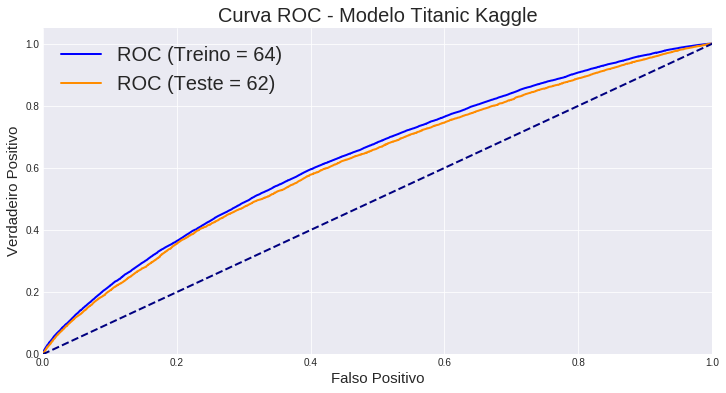

Acurácia, Gini e Área Curva ROC (Base de Treino):  91.88 28.000000000000004 64.0
Acurácia, Gini e Área Curva ROC (Base de Teste):  92.04 24.0 62.0


In [44]:
# 1) Cálculo da acurácia
from sklearn.metrics import accuracy_score

#Treino
acc_gbc_train = round(accuracy_score(y_pred_gbc_train, y_train) * 100, 2)

#Teste
acc_gbc_test = round(accuracy_score(y_pred_gbc_test, y_test) * 100, 2)

# 2) Cálculo da área sob curva ROC e Gini
from sklearn.metrics import roc_curve, auc

# Treino
fpr_gbc_train, tpr_gbc_train, thresholds = roc_curve(y_train, y_score_gbc_train)
roc_auc_gbc_train = 100*round(auc(fpr_gbc_train, tpr_gbc_train), 2)
gini_gbc_train = 100*round((2*roc_auc_gbc_train/100 - 1), 2)

# Teste
fpr_gbc_test, tpr_gbc_test, thresholds = roc_curve(y_test, y_score_gbc_test)
roc_auc_gbc_test = 100*round(auc(fpr_gbc_test, tpr_gbc_test), 2)
gini_gbc_test = 100*round((2*roc_auc_gbc_test/100 - 1), 2)


# 3) Gráfico da curva ROC
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(12,6))

lw = 2

plt.plot(fpr_gbc_train, tpr_gbc_train, color='blue',lw=lw, label='ROC (Treino = %0.0f)' % roc_auc_gbc_train)
plt.plot(fpr_gbc_test, tpr_gbc_test, color='darkorange',lw=lw, label='ROC (Teste = %0.0f)' % roc_auc_gbc_test)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falso Positivo', fontsize=15)
plt.ylabel('Verdadeiro Positivo', fontsize=15)
plt.legend(loc="lower right")
plt.legend(fontsize=20) 
plt.title('Curva ROC - Modelo Titanic Kaggle', fontsize=20)
plt.show()

print('Acurácia, Gini e Área Curva ROC (Base de Treino): ',acc_gbc_train, gini_gbc_train, roc_auc_gbc_train)
print('Acurácia, Gini e Área Curva ROC (Base de Teste): ',acc_gbc_test, gini_gbc_test, roc_auc_gbc_test)